Try:

```
[ ] Way more bits.
[ ] Soft version.
[ ] No narrow in gumble sampling.
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F

In [4]:
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.utils.data

In [5]:
CUDA = torch.cuda.is_available()

In [6]:
#transform
data_transforms = transforms.Compose([
        transforms.ToTensor(),
        lambda x: x>0.5,
        lambda x: x.float(),
    ])

In [7]:
# dataset loading
bsize = 100
train_loader = torch.utils.data.DataLoader(
    dset.MNIST('data', train=True, download=True, transform=data_transforms), batch_size=bsize, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    dset.MNIST('data', train=False, download=True, transform=data_transforms), batch_size=bsize, shuffle=True)

In [40]:
# hyperparameters
N = 3
k = 2
tau = 1.

In [41]:
# TODO: UPDATE TO BINARY GUMBEL (REFER TO L0-REG PAPER)
# gumbel-softmax
def sample_gumbel(shape, eps=1e-20):
    U = torch.rand(shape)
    v = Variable(torch.log(-torch.log(U + eps) + eps))
    if CUDA:
        v = v.cuda()
    return -v

def gumbel_softmax_sample(logits, temperature):
    y = logits + sample_gumbel(logits.size())
    return F.softmax(y / temperature, dim=-1)

def gumbel_softmax(logits, temperature):
    """
    input: [*, n_class]
    return: [*, n_class] an one-hot vector
    """
    y = gumbel_softmax_sample(logits, temperature)
    shape = y.size()
    _, ind = y.max(dim=-1)
    y_hard = torch.zeros_like(y).view(-1, shape[-1])
    y_hard.scatter_(1, ind.view(-1, 1), 1)
    y_hard = y_hard.view(*shape)
    return (y_hard - y).detach() + y

In [42]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 2*N),
            nn.ReLU(),
        )
        
    def forward(self, x):
        bits = self.net(x)
        bits = bits.view(-1, N, 2)
        return bits

In [43]:
def prob(outputs, N=N, k=k):
    outputs = [F.softmax(out, dim=-1) for out in outputs]
    return torch.cat(outputs, dim=1).view(-1, N, k)

def sample(l):
    gs = gumbel_softmax(l, tau)
    return gs.narrow(1,0,1)

In [44]:
class Decoder(nn.Module):
    def __init__(self, n_bits):
        super(Decoder, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(n_bits, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.Sigmoid(),
        )
        
    def forward(self, x):
        return self.net(x)

# class RecDecoderHead(nn.Module):
#     def __init__(self):
#         super(RecDecoderHead, self).__init__()
#         self.fc = nn.Linear(1, 128)
#         self.relu = nn.ReLU()
    
#     def forward(self, x):
#         return self.relu(self.fc(x))
    
# class RecDecoderBody(nn.Module):
#     def __init__(self):
#         super(RecDecoderBody, self).__init__()
#         self.fc = nn.Linear(129, 128) # prev state + hidden
#         self.relu = nn.ReLU()
    
#     def forward(self, x):
#         return self.relu(self.fc(x))
    
# class RecDecoderTail(nn.Module):  
#     def __init__(self):
#         super(RecDecoderTail, self).__init__()
#         self.fc1 = nn.Linear(128, 256)
#         self.fc2 = nn.Linear(256, 512)      
#         self.fc3 = nn.Linear(512, 784)
#         self.relu = nn.ReLU()
        
#     def forward(self, x):
#         h1 = self.relu(self.fc1(x))
#         h2 = self.relu(self.fc2(h1))
#         h3 = self.fc3(h2)
#         o = h3.view(-1,784)
#         return F.sigmoid(o)    

In [45]:
E = Encoder()
Ds = [Decoder(d) for d in range(1, N+1)]
# D_head = RecDecoderHead()
# D_body = [RecDecoderBody() for _ in range(N-1)]
# D_tail = RecDecoderTail()

In [46]:
if CUDA:
    E.cuda()
    [D.cuda() for D in Ds]
#     D_head.cuda()
#     [e.cuda() for e in D_body]
#     D_tail.cuda()

In [51]:
from itertools import product
    
log_two_pow_ns = []

for n in range(N+1):
    log_two_pow_n = Variable(torch.Tensor([2**n]).log(), requires_grad=False)
    if CUDA:
        log_two_pow_n = log_two_pow_n.cuda()
    log_two_pow_ns.append(log_two_pow_n)

def get_dependent_prior_loss(x):
    acc = Variable(torch.zeros(2**N))
    if CUDA:
        acc = acc.cuda()
    acc_i = 0
    
    batch_size = x.shape[0]
    
    def get_kl(q, path, n, batch_size):
        _idx = path.data
        select_mat = Variable(torch.stack([1-_idx, _idx]).t(), requires_grad=False)
        if CUDA:
            select_mat = select_mat.cuda()
        select_mat = select_mat.expand(torch.Size([batch_size]) + select_mat.shape)
        probs = q.mul(select_mat).sum(-1) # shape (batch x N)
        log_q = (probs+1e-20).log().sum(-1) # shape (batch)
        kl_term = log_q.exp().mul(log_two_pow_ns[n] + log_q) # shape (batch)
        kl_term = kl_term.mean() # shape (1) - take sum over minibatch
        return kl_term
    
    for _path in product(range(2), repeat=N):
        path = Variable(torch.Tensor(_path), requires_grad=False)
        if CUDA:
            path = path.cuda()
        
        outputs = E(x)
        outputs = outputs.permute(1,0,2) # make it like the list we had before

        kl_term = 0
        
        for nn in range(1, N+1):
            q = prob(outputs[:nn], nn)
            kl_term += get_kl(q, path[:nn], nn, batch_size)

        acc[acc_i] = kl_term
        acc_i += 1

    return acc.sum()

In [52]:
# TESTING
# Hacky! Getting a data point.
for batch_idx, (data, _) in enumerate(train_loader):
    data = Variable(data)
    if CUDA:
        data = data.cuda()
    x = data.view(-1,784)
    x = x[0:4]
    break
    
get_dependent_prior_loss(x)

Variable containing:
1.00000e-03 *
  1.1064
[torch.cuda.FloatTensor of size 1 (GPU 0)]

In [94]:
def loss_function(recons, x):
    _bsize = x.shape[0]
    BCES = [F.binary_cross_entropy(recon_x, x, size_average=False)/_bsize for recon_x in recons]
    BCE = sum(BCES)
    
    # Assuming dependent latent
    KLD = get_dependent_prior_loss(x) # this sums together the KLD
    
    return BCE, KLD

In [54]:
params = [
    {'params':E.parameters()}
] + [{'params':d.parameters()} for d in Ds]
optimizer = optim.Adam(params, lr=1e-4)

In [55]:
best_loss_sofar = 9999

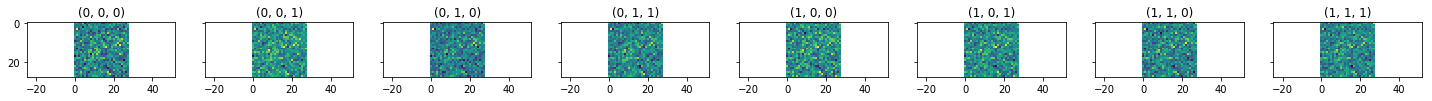

In [60]:
from itertools import product

def debug():
    f, axes = plt.subplots(1, 2**N, sharey=True, figsize=(25,1))
    kk = 0

    def make_variable(value):
        t = torch.Tensor([value]).type(torch.FloatTensor)
        v = Variable(t)
        if CUDA:
            v = v.cuda()
        return v

    for path in product(range(2), repeat=N):
        v = make_variable(path)
        w = Ds[-1](v)

        ax = axes[kk]
        ax.set_title(path)
        ax.imshow(w.view(28,28).cpu().data.numpy())
        kk += 1
    plt.show()
    
debug()

In [101]:
def train(epoch):
    global best_loss_sofar
    train_bce_loss = 0
    train_kld_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = Variable(data)
        if CUDA:
            data = data.cuda()
        x = data.view(-1,784)
        optimizer.zero_grad()
        outputs = E(x)
        recons = []
        samples = []
        for nn in range(N):
            s = sample(outputs[:,nn,:])
            samples.append(s)
            inp = torch.cat(samples, 1)
            recons.append(Ds[nn](inp))

        BCE, KLD = loss_function(recons, x)
        loss = BCE + KLD
        loss.backward()
        optimizer.step()  
        train_bce_loss += BCE.data[0]
        train_kld_loss += KLD.data[0]
        
        if batch_idx % 200 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tBCE loss: {:.6f}\tKLD loss: {:.6f}'.format(
                epoch+1, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                BCE.data[0] / len(data),
                KLD.data[0] / len(data)))
            
    avg_bce_loss = train_bce_loss / len(train_loader.dataset)
    avg_kld_loss = train_kld_loss / len(train_loader.dataset)
    avg_loss = avg_bce_loss + avg_kld_loss
    print('====> Epoch: {} Average BCE loss: {:.4f}, Average KLD loss: {:.4f}, Total: {:.4f}'.format(
          epoch+1, avg_bce_loss, avg_kld_loss, avg_loss))
    
    if avg_loss < best_loss_sofar:
        print("Loss {} is better than previous best {}, saving model".format(avg_loss, best_loss_sofar))
#         save_model()
        best_loss_sofar = avg_loss
        debug()
        
#     return q, bits # debugging

Train Epoch: 1 [0/60000 (0%)]	BCE loss: 6.371863	KLD loss: 0.076213
Train Epoch: 1 [20000/60000 (33%)]	BCE loss: 6.171196	KLD loss: 0.076239
Train Epoch: 1 [40000/60000 (67%)]	BCE loss: 6.082847	KLD loss: 0.076243
====> Epoch: 1 Average BCE loss: 6.1898, Average KLD loss: 0.0762, Total: 6.2661
Loss 6.266061156709989 is better than previous best 7.116609207172784, saving model


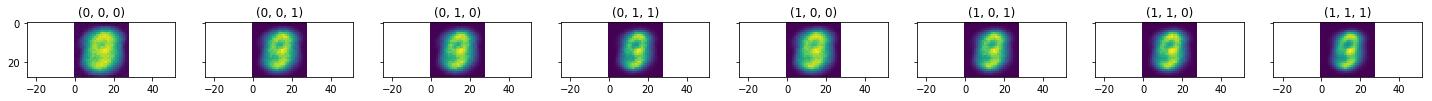

Train Epoch: 2 [0/60000 (0%)]	BCE loss: 6.116738	KLD loss: 0.076244
Train Epoch: 2 [20000/60000 (33%)]	BCE loss: 6.261466	KLD loss: 0.076241
Train Epoch: 2 [40000/60000 (67%)]	BCE loss: 6.223342	KLD loss: 0.076243
====> Epoch: 2 Average BCE loss: 6.1880, Average KLD loss: 0.0762, Total: 6.2642
Loss 6.26421408847173 is better than previous best 6.266061156709989, saving model


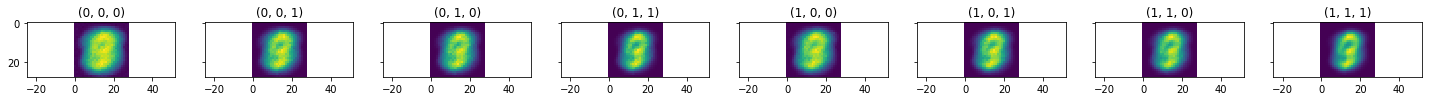

Train Epoch: 3 [0/60000 (0%)]	BCE loss: 6.482314	KLD loss: 0.076246
Train Epoch: 3 [20000/60000 (33%)]	BCE loss: 6.128741	KLD loss: 0.076246
Train Epoch: 3 [40000/60000 (67%)]	BCE loss: 6.378204	KLD loss: 0.076245
====> Epoch: 3 Average BCE loss: 6.1870, Average KLD loss: 0.0762, Total: 6.2632
Loss 6.263249727718035 is better than previous best 6.26421408847173, saving model


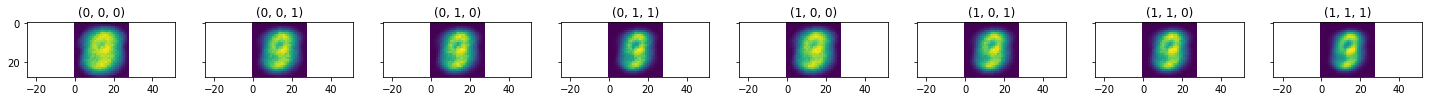

Train Epoch: 4 [0/60000 (0%)]	BCE loss: 5.930195	KLD loss: 0.076245
Train Epoch: 4 [20000/60000 (33%)]	BCE loss: 6.195616	KLD loss: 0.076246
Train Epoch: 4 [40000/60000 (67%)]	BCE loss: 6.175596	KLD loss: 0.076246
====> Epoch: 4 Average BCE loss: 6.1867, Average KLD loss: 0.0762, Total: 6.2630
Loss 6.262978378152847 is better than previous best 6.263249727718035, saving model


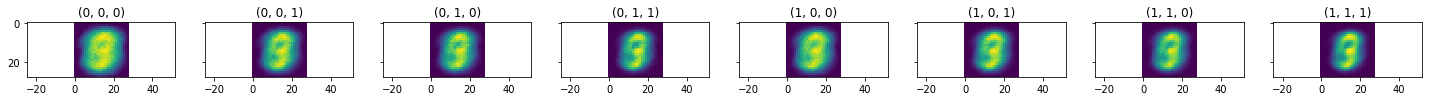

Train Epoch: 5 [0/60000 (0%)]	BCE loss: 6.267228	KLD loss: 0.076245
Train Epoch: 5 [20000/60000 (33%)]	BCE loss: 6.218600	KLD loss: 0.076246
Train Epoch: 5 [40000/60000 (67%)]	BCE loss: 5.980978	KLD loss: 0.076246
====> Epoch: 5 Average BCE loss: 6.1868, Average KLD loss: 0.0762, Total: 6.2630
Train Epoch: 6 [0/60000 (0%)]	BCE loss: 6.190355	KLD loss: 0.076246
Train Epoch: 6 [20000/60000 (33%)]	BCE loss: 5.966746	KLD loss: 0.076246
Train Epoch: 6 [40000/60000 (67%)]	BCE loss: 6.130856	KLD loss: 0.076246
====> Epoch: 6 Average BCE loss: 6.1866, Average KLD loss: 0.0762, Total: 6.2628
Loss 6.262821920156479 is better than previous best 6.262978378152847, saving model


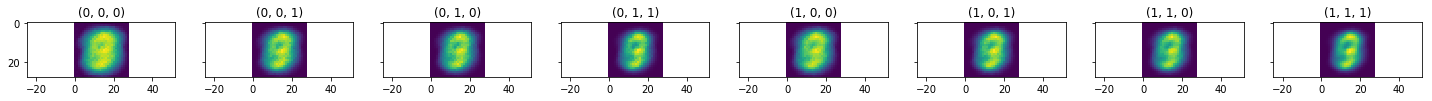

Train Epoch: 7 [0/60000 (0%)]	BCE loss: 6.041826	KLD loss: 0.076246
Train Epoch: 7 [20000/60000 (33%)]	BCE loss: 6.094099	KLD loss: 0.076246
Train Epoch: 7 [40000/60000 (67%)]	BCE loss: 6.400712	KLD loss: 0.076246
====> Epoch: 7 Average BCE loss: 6.1866, Average KLD loss: 0.0762, Total: 6.2628
Loss 6.262803372001648 is better than previous best 6.262821920156479, saving model


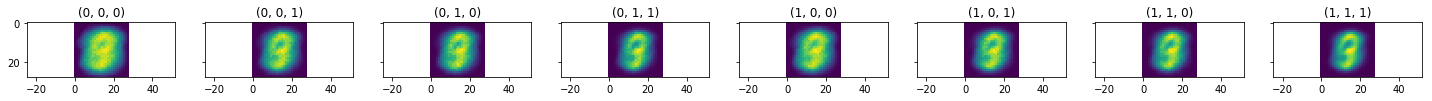

Train Epoch: 8 [0/60000 (0%)]	BCE loss: 6.083615	KLD loss: 0.076246
Train Epoch: 8 [20000/60000 (33%)]	BCE loss: 6.363914	KLD loss: 0.076246
Train Epoch: 8 [40000/60000 (67%)]	BCE loss: 5.861238	KLD loss: 0.076246
====> Epoch: 8 Average BCE loss: 6.1862, Average KLD loss: 0.0762, Total: 6.2625
Loss 6.262454344805081 is better than previous best 6.262803372001648, saving model


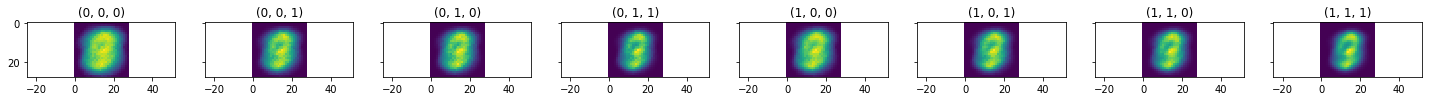

Train Epoch: 9 [0/60000 (0%)]	BCE loss: 6.176425	KLD loss: 0.076246
Train Epoch: 9 [20000/60000 (33%)]	BCE loss: 6.478938	KLD loss: 0.076246
Train Epoch: 9 [40000/60000 (67%)]	BCE loss: 6.061528	KLD loss: 0.076246
====> Epoch: 9 Average BCE loss: 6.1859, Average KLD loss: 0.0762, Total: 6.2621
Loss 6.262143939820925 is better than previous best 6.262454344805081, saving model


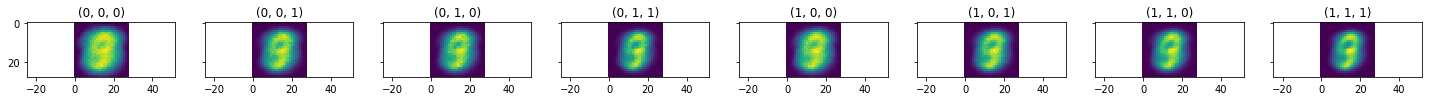

Train Epoch: 10 [0/60000 (0%)]	BCE loss: 6.421729	KLD loss: 0.076246
Train Epoch: 10 [20000/60000 (33%)]	BCE loss: 6.182396	KLD loss: 0.076246
Train Epoch: 10 [40000/60000 (67%)]	BCE loss: 6.118632	KLD loss: 0.076246
====> Epoch: 10 Average BCE loss: 6.1857, Average KLD loss: 0.0762, Total: 6.2619
Loss 6.261908013971647 is better than previous best 6.262143939820925, saving model


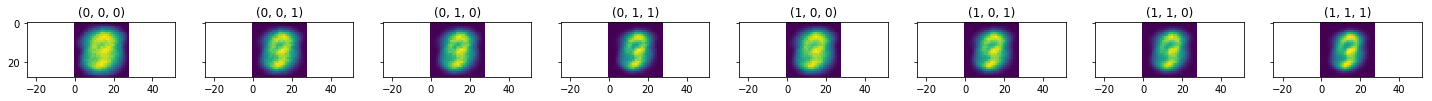

Train Epoch: 11 [0/60000 (0%)]	BCE loss: 6.294733	KLD loss: 0.076246
Train Epoch: 11 [20000/60000 (33%)]	BCE loss: 6.124987	KLD loss: 0.076244
Train Epoch: 11 [40000/60000 (67%)]	BCE loss: 6.125458	KLD loss: 0.076246
====> Epoch: 11 Average BCE loss: 6.1854, Average KLD loss: 0.0762, Total: 6.2616
Loss 6.261607150363923 is better than previous best 6.261908013971647, saving model


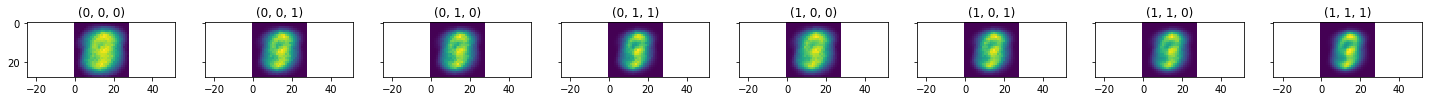

Train Epoch: 12 [0/60000 (0%)]	BCE loss: 6.053926	KLD loss: 0.076241
Train Epoch: 12 [20000/60000 (33%)]	BCE loss: 5.930374	KLD loss: 0.034428
Train Epoch: 12 [40000/60000 (67%)]	BCE loss: 5.750128	KLD loss: 0.037703
====> Epoch: 12 Average BCE loss: 6.0168, Average KLD loss: 0.0431, Total: 6.0599
Loss 6.059934697890282 is better than previous best 6.261607150363923, saving model


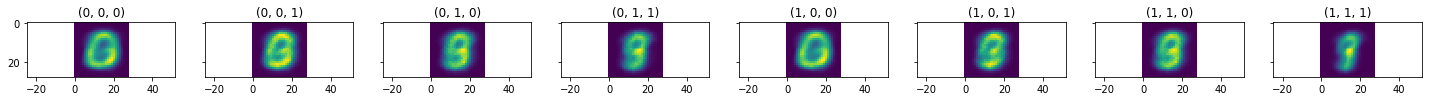

Train Epoch: 13 [0/60000 (0%)]	BCE loss: 6.013629	KLD loss: 0.036163
Train Epoch: 13 [20000/60000 (33%)]	BCE loss: 6.167801	KLD loss: 0.034615
Train Epoch: 13 [40000/60000 (67%)]	BCE loss: 6.042751	KLD loss: 0.033631
====> Epoch: 13 Average BCE loss: 5.9269, Average KLD loss: 0.0355, Total: 5.9623
Loss 5.96234228875637 is better than previous best 6.059934697890282, saving model


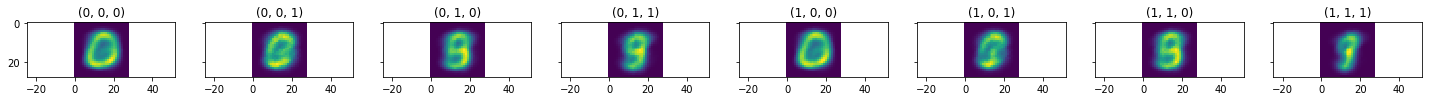

Train Epoch: 14 [0/60000 (0%)]	BCE loss: 5.912151	KLD loss: 0.035065
Train Epoch: 14 [20000/60000 (33%)]	BCE loss: 5.728655	KLD loss: 0.039188
Train Epoch: 14 [40000/60000 (67%)]	BCE loss: 5.940219	KLD loss: 0.052736
====> Epoch: 14 Average BCE loss: 5.8427, Average KLD loss: 0.0428, Total: 5.8855
Loss 5.885511977259318 is better than previous best 5.96234228875637, saving model


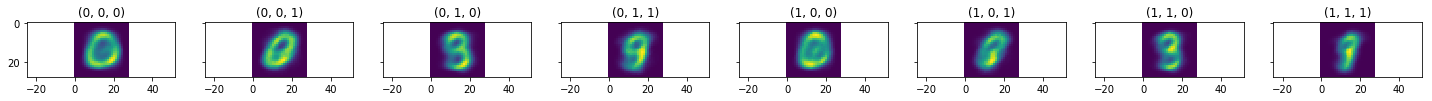

Train Epoch: 15 [0/60000 (0%)]	BCE loss: 5.837714	KLD loss: 0.050504
Train Epoch: 15 [20000/60000 (33%)]	BCE loss: 5.844034	KLD loss: 0.046464
Train Epoch: 15 [40000/60000 (67%)]	BCE loss: 5.501824	KLD loss: 0.053193
====> Epoch: 15 Average BCE loss: 5.6920, Average KLD loss: 0.0522, Total: 5.7442
Loss 5.74418713110288 is better than previous best 5.885511977259318, saving model


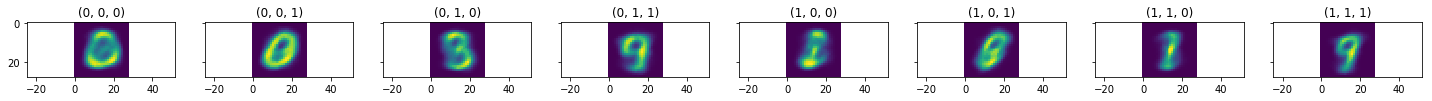

Train Epoch: 16 [0/60000 (0%)]	BCE loss: 5.745703	KLD loss: 0.049855
Train Epoch: 16 [20000/60000 (33%)]	BCE loss: 5.690381	KLD loss: 0.055142
Train Epoch: 16 [40000/60000 (67%)]	BCE loss: 5.447637	KLD loss: 0.054499
====> Epoch: 16 Average BCE loss: 5.6460, Average KLD loss: 0.0528, Total: 5.6987
Loss 5.698729217100144 is better than previous best 5.74418713110288, saving model


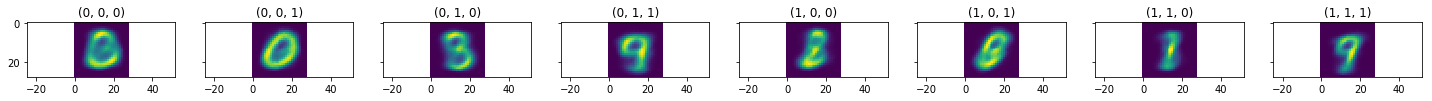

Train Epoch: 17 [0/60000 (0%)]	BCE loss: 5.665919	KLD loss: 0.056313
Train Epoch: 17 [20000/60000 (33%)]	BCE loss: 5.655214	KLD loss: 0.054501
Train Epoch: 17 [40000/60000 (67%)]	BCE loss: 5.668317	KLD loss: 0.053534
====> Epoch: 17 Average BCE loss: 5.6355, Average KLD loss: 0.0532, Total: 5.6888
Loss 5.688790051444371 is better than previous best 5.698729217100144, saving model


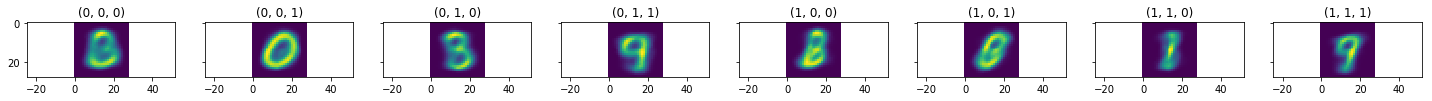

Train Epoch: 18 [0/60000 (0%)]	BCE loss: 5.470612	KLD loss: 0.053393
Train Epoch: 18 [20000/60000 (33%)]	BCE loss: 5.739799	KLD loss: 0.054876
Train Epoch: 18 [40000/60000 (67%)]	BCE loss: 5.533298	KLD loss: 0.054554
====> Epoch: 18 Average BCE loss: 5.6309, Average KLD loss: 0.0532, Total: 5.6841
Loss 5.684109635233879 is better than previous best 5.688790051444371, saving model


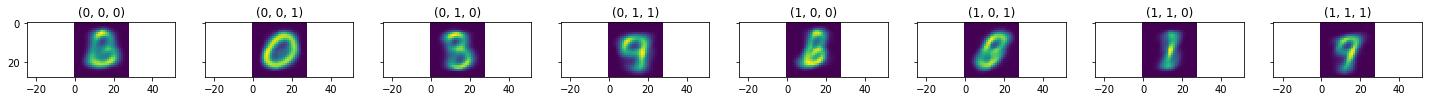

Train Epoch: 19 [0/60000 (0%)]	BCE loss: 5.698854	KLD loss: 0.052138
Train Epoch: 19 [20000/60000 (33%)]	BCE loss: 5.526847	KLD loss: 0.056212
Train Epoch: 19 [40000/60000 (67%)]	BCE loss: 5.533086	KLD loss: 0.053331
====> Epoch: 19 Average BCE loss: 5.6262, Average KLD loss: 0.0534, Total: 5.6797
Loss 5.679662615346908 is better than previous best 5.684109635233879, saving model


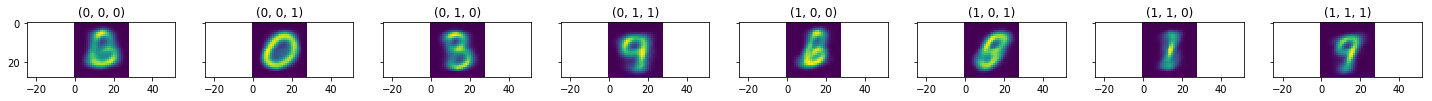

Train Epoch: 20 [0/60000 (0%)]	BCE loss: 5.392465	KLD loss: 0.056702


In [ ]:
%%time
for epoch in range(100):
    train(epoch)

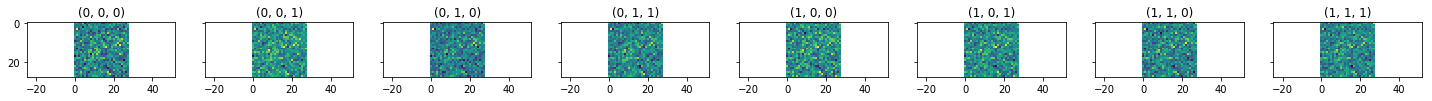

In [63]:
debug()